## Initial Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('customer.csv')
data.reset_index(drop=True, inplace=True)

### Analysis

To begin, we analyzed the population data.
Our initial step was to examine the ages of individuals with and without health insurance.

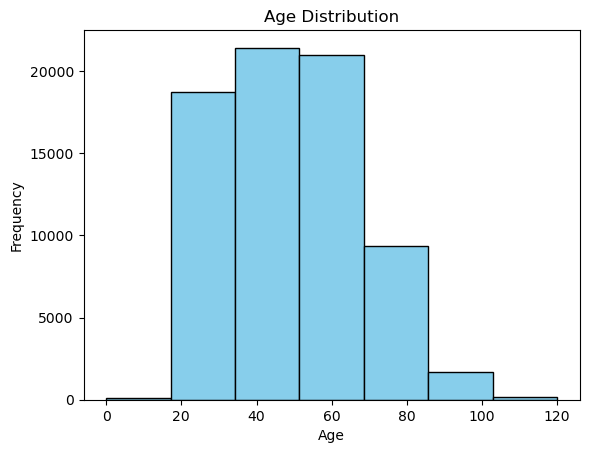

In [24]:
data['age'].plot(kind='hist', bins=7, color='skyblue', edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.show()

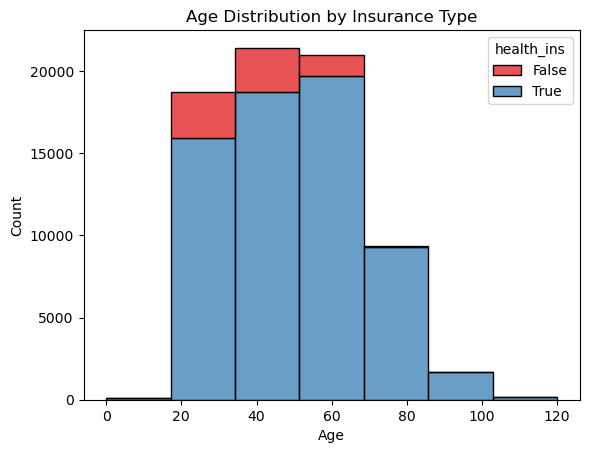

In [25]:
sns.histplot(data=data, x='age', hue='health_ins', multiple='stack', bins=7, palette='Set1')
plt.title('Age Distribution by Insurance Type')
plt.xlabel('Age')
plt.show()

From the graph above, we observed that the population includes individuals from all age groups. However, there are fewer individuals over 70 years old, which is expected given the smaller size of this age group. Next, we created a violin plot to examine their affluence and analyzed the details of the income column.

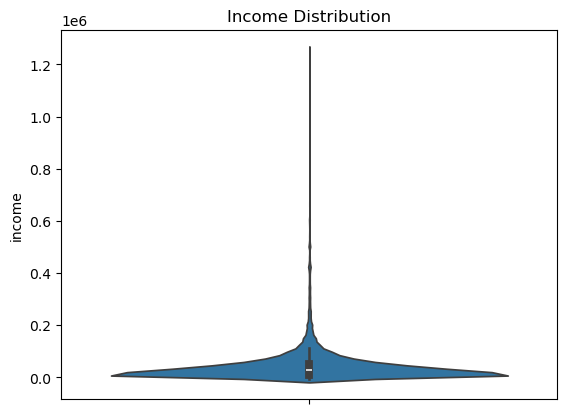

In [26]:
sns.violinplot(data['income'])
plt.title('Income Distribution')
plt.show()

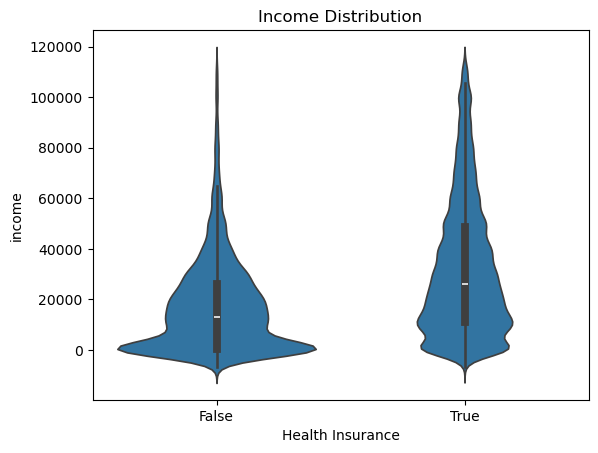

In [27]:
# remove outliers from income and represent a violin plot, one side with health_insurance and the other without
Q1 = data['income'].quantile(0.25)
Q3 = data['income'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
data_outliers = data[(data['income'] >= lower_bound) & (data['income'] <= upper_bound)]


sns.violinplot(x="health_ins", y="income", data=data_outliers)
plt.title('Income Distribution')
plt.xlabel('Health Insurance')
plt.show()

In [28]:

data[['income']].describe()

,income
count,7.245800e+04
mean,4.188143e+04
std,5.827460e+04
min,-6.900000e+03
25%,1.070000e+04
50%,2.640000e+04
75%,5.200000e+04
max,1.257000e+06


We created a histogram to visualize the distribution of individuals across different states represented in the dataset.

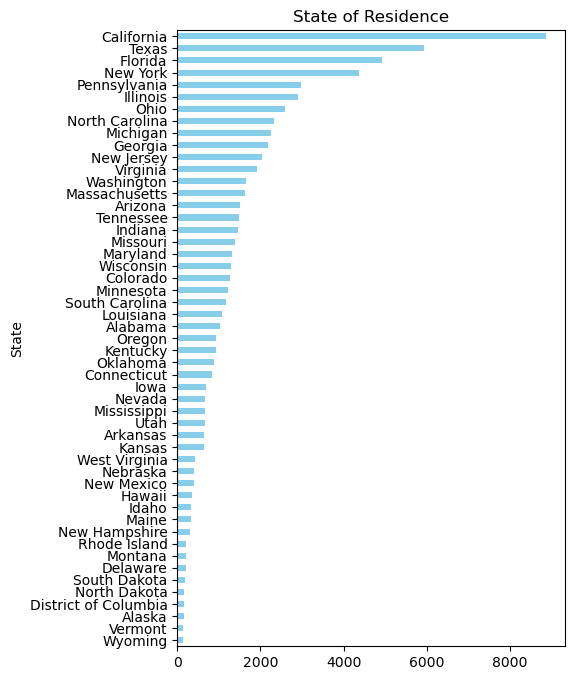

In [29]:
fig, ax = plt.subplots(figsize=(5, 8))
data['state_of_res'].value_counts().sort_values().plot(kind='barh', color='skyblue', ax=ax)
plt.title('State of Residence')
plt.ylabel('State')
plt.show()

We investigated potential relationships between income and variables such as age, gender, and marital status. This analysis aimed to uncover any significant patterns or correlations among these factors.

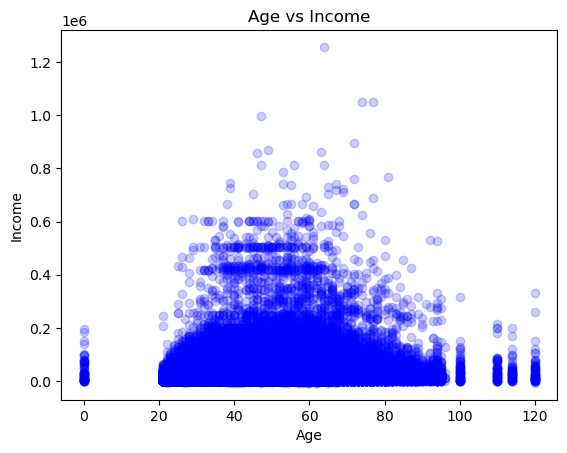

In [30]:
plt.scatter(data['age'], data['income'], color='blue', alpha=0.2)
plt.title('Age vs Income')
plt.xlabel('Age')
plt.ylabel('Income')
plt.show()

The distribution of income by age closely resembles a normal distribution.

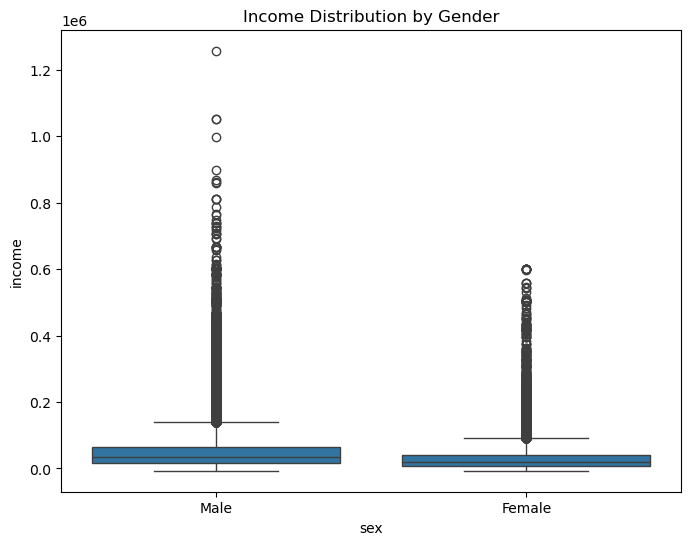

In [31]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=data, x='sex', y='income')
plt.title('Income Distribution by Gender')
plt.show()

Males have higher income than females.

For the marital distribution, it is expected that individuals who have 'Never Married' are generally younger, which explains their lower income. A similar pattern is observed for widowed individuals. To explore this further, we created violin plots, dividing the data into two groups: those under 50 years old on the left and those over 50 years old on the right.

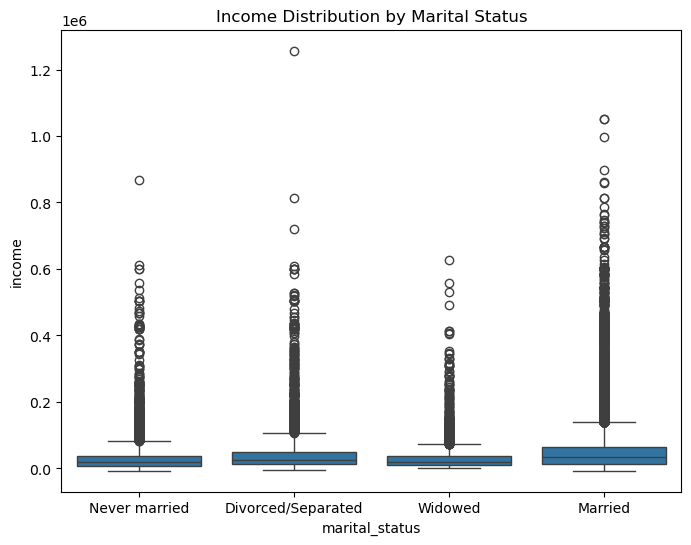

In [32]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=data, x='marital_status', y='income')
plt.title('Income Distribution by Marital Status')
plt.show()

xyz falta a castro mudar isto

We analyzed the relationship between housing type, number of rooms and recent move (True or False) to identify any significant patterns or correlations.

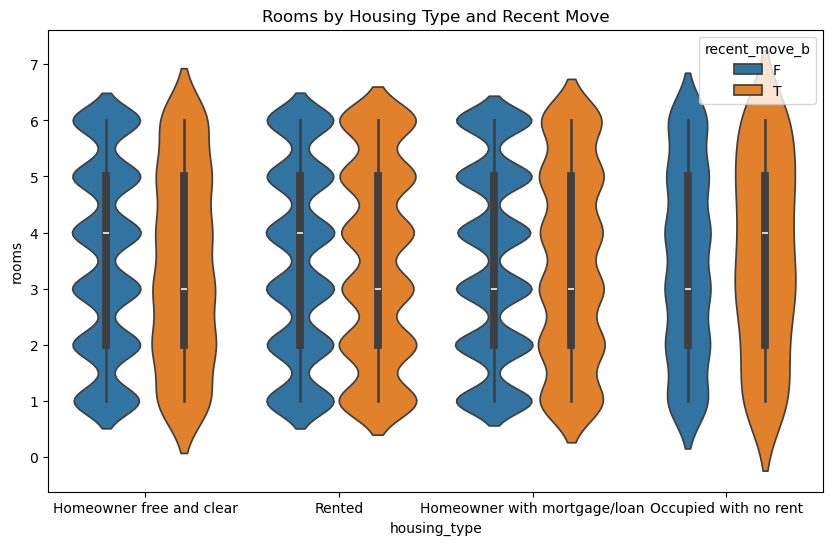

In [33]:
# Are the characteristics of the housing situation interrelated?

plt.figure(figsize=(10, 6))
sns.violinplot(data=data, x='housing_type', y='rooms', hue='recent_move_b')
plt.title('Rooms by Housing Type and Recent Move')
plt.show()

We could not find any relationship.

### Relationships

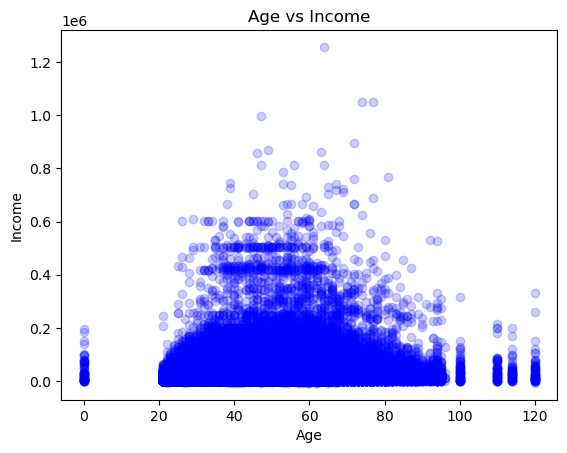

In [34]:
# What is the relation between age and income?

plt.scatter(data['age'], data['income'], color='blue', alpha=0.2)
plt.title('Age vs Income')
plt.xlabel('Age')
plt.ylabel('Income')
plt.show()

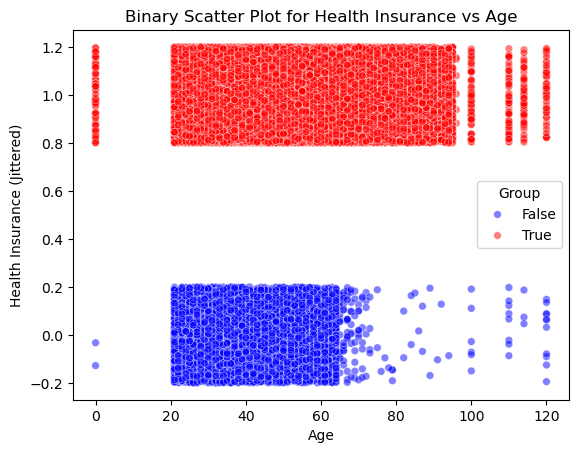

In [35]:
# Visualize the probability of health insurance by age?

data_copy = data.copy()

data_copy['hi_jittered'] = data['health_ins'] + np.random.uniform(-0.2, 0.2, size=len(data))

sns.scatterplot(data=data_copy, x='age', y='hi_jittered', hue='health_ins', palette={0: 'blue', 1: 'red'}, s=30, alpha=0.5)
plt.title('Binary Scatter Plot for Health Insurance vs Age')
plt.xlabel('Age')
plt.ylabel('Health Insurance (Jittered)')
plt.legend(title='Group')
plt.show()

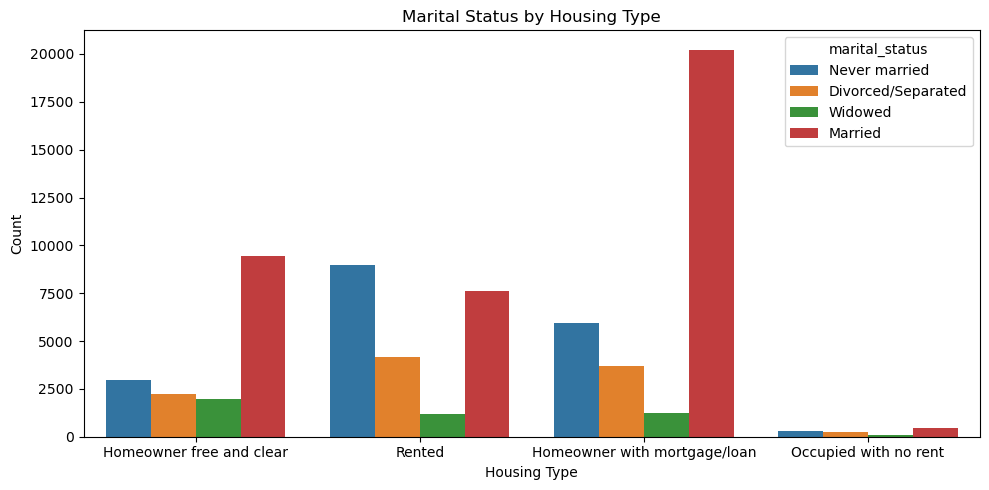

In [36]:
# Visualize the marital status according to the housing type?

plt.figure(figsize=(10, 5))
sns.countplot(x='housing_type', hue='marital_status', data=data)
plt.title('Marital Status by Housing Type')
plt.xlabel('Housing Type')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

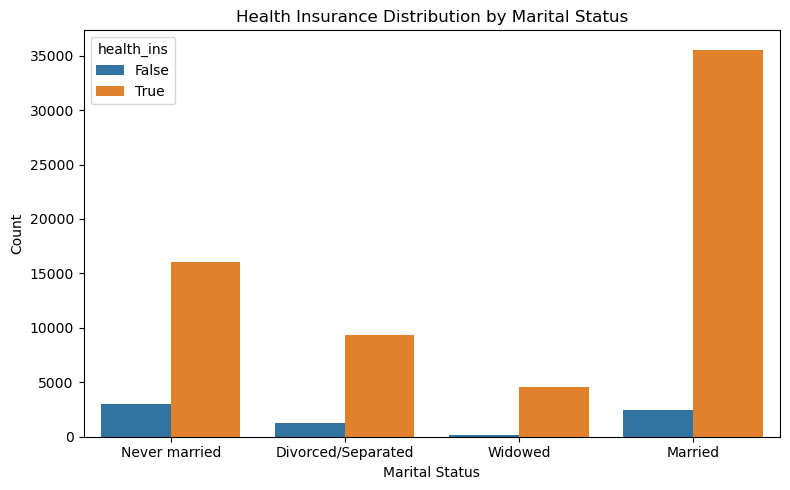

In [37]:
# How the health insurance distributes according to the marital status (suggestion: use stacked barplots
# with colored histograms per category)?

plt.figure(figsize=(8, 5))
sns.countplot(x='marital_status', hue='health_ins', data=data)

plt.title('Health Insurance Distribution by Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Count')
plt.tight_layout()

plt.show()

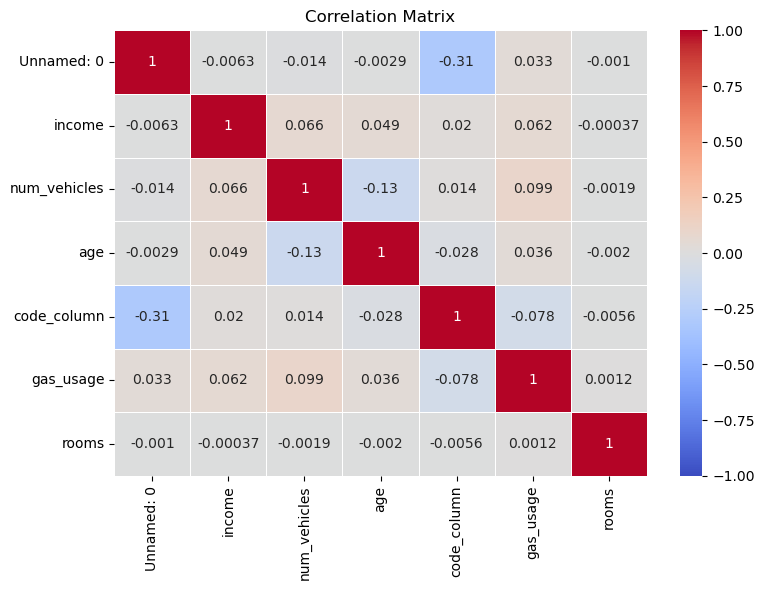

In [38]:
# Explore correlations between all variables

numeric_data = data.select_dtypes(include=['number'])
corr = numeric_data.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()


In [ ]:
numeric_data_1 = numeric_data.join(data['health_ins'])
numeric_data_1.drop(columns=['Unnamed: 0'], inplace=True)

sns.pairplot(data=numeric_data_1, hue='health_ins')

KeyboardInterrupt: 

## Preprocessing

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import seaborn as sns
from scipy.stats import zscore
import math
from sklearn.impute import KNNImputer



In [3]:
def preprocess_data(data):
    # The Unnamed: 0 column resulted from saving the csv file
    data.drop('Unnamed: 0', axis=1, inplace=True) 
    
    # Replace the null values in the 'is_employed' column with 'False' (empty means no employment)
    data.fillna({'is_employed': 'False'}, inplace=True)

    data['recent_move_b'] = data['recent_move_b'].apply(lambda x: True if x == 'T' else False)

    data['is_employed'] = data['is_employed'].apply(lambda x: True if x == 'True' else False)

    data.drop('custid', axis=1, inplace=True)

    # In the dictionary, we are indicated that the values 1, 2, 3 indicate special cases which we decided to separate
    data['gas_payment'] = data['gas_usage'].replace([x for x in data['gas_usage'] if x not in [1, 2, 3]], 0)
    data['gas_bill'] = data['gas_usage'].replace([x for x in data['gas_usage'] if x in [1, 2, 3]], 0)

    data.drop('gas_usage', axis=1, inplace=True)

    return data

    

In [4]:
data = pd.read_csv('customer.csv')

data = preprocess_data(data)

In [5]:
# Print the columns with missing values
print(f' --- PRE CLEANING --- \nColumns with missing values: \n{data.isna().sum()}')
old_len = len(data)
print('Length of the dataframe: ', old_len)   

# Drop rows with missing values except age column
data.dropna(inplace=True)


print(f'\n --- POST CLEANING --- \nLength of the dataframe: {len(data)}')
print('Number of rows dropped: ', old_len - len(data))

 --- PRE CLEANING --- 
Columns with missing values: 
sex                  0
is_employed          0
income               0
marital_status       0
health_ins           0
housing_type      1686
num_vehicles      1686
age                  0
state_of_res         0
code_column          0
rooms                0
recent_move_b        0
gas_payment          0
gas_bill          1686
dtype: int64
Length of the dataframe:  72458

 --- POST CLEANING --- 
Length of the dataframe: 70772
Number of rows dropped:  1686


In [6]:
data['age'] = data['age'].replace(0, np.nan)

In [18]:
scaling_cols = ['income', 'gas_payment'] # Columns to scale
scaling_df = data[scaling_cols]

data_log = data.copy()
data_log[scaling_cols] = np.log1p(scaling_df)
data_log.dropna(subset=scaling_cols, inplace=True)

# Dataset with zscore scaling
data_zs = data.copy()
data_zs[scaling_cols] = scaling_df.apply(zscore)

data_mm = data.copy()

datasets = {
    'E': {'name': 'Only Encoding',
          'base': data.copy(), # Only encoding
          }, 
    'E-MM': {'name': 'Encoding and MinMax',
          'base': data.copy(), # Encoding and MinMax
          }, 
    'E-MM-L': {'name': 'Encoding, MinMax and Log',
          'base': data_log.copy(), # Encoding, MinMax and Log
          }, 
    'E-MM-Z': {'name': 'Encoding, MinMax and Z-score',
          'base': data_zs.copy(), # Encoding, MinMax and Z-score
          }, 
}


for key in datasets:
      data = datasets[key]['base'].copy()
      numerical_cols = data.select_dtypes(include=[np.number])
      cols = (numerical_cols-numerical_cols.min())/(numerical_cols.max()-numerical_cols.min())
      data[numerical_cols.columns] = cols
      datasets[key]['minmax'] = data
      datasets[key]['minmax_values'] = (numerical_cols.min(), numerical_cols.max()) 


In [19]:
from sklearn.preprocessing import OneHotEncoder

for key in datasets:
    df = datasets[key]['minmax'].copy()
    categorical_cols = df.select_dtypes(include=[object])

    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoded_array = encoder.fit_transform(categorical_cols)
    encoded_df = pd.DataFrame(
        encoded_array,
        columns=encoder.get_feature_names_out(categorical_cols.columns),
        index=df.index
    )
    
    df.drop(columns=categorical_cols.columns, inplace=True)
    df = pd.concat([df, encoded_df], axis=1)
    datasets[key]['encoded'] = df
    datasets[key]['encoder'] = encoder


In [20]:
for key in datasets:
    df = datasets[key]['encoded'].copy()
    imputer = KNNImputer(n_neighbors=5)
    imputed_data = imputer.fit_transform(df)
    df['age'] = imputed_data[:, 4] 
    datasets[key]['imputed'] = df.copy()

In [382]:
# save all dfs processed in csv
for key in datasets:
    df = datasets[key]['imputed']
    df.to_csv(f'processed_df_{key}.csv', index=False)

## Algorithms

### Functions

In [27]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
import pickle

In [28]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    metrics = {}
    
    metrics['accuracy'] = accuracy_score(y_test, y_pred)
    
    metrics['precision'] = precision_score(y_test, y_pred)  # or 'macro' for multiclass
    
    metrics['recall'] = recall_score(y_test, y_pred)  # or 'macro'
    
    metrics['f1_score'] = f1_score(y_test, y_pred)  # or 'macro'
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    [[tn, fp], [fn, tp]] = conf_matrix
    metrics['specifity'] = tn / (tn+fp)
    
    metrics['confusion_matrix'] = conf_matrix

    print(classification_report(y_test, y_pred, digits=6))
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, y_pred))
    
    return metrics

In [29]:
def train_model(model, X, y, test_size = 0.3, param_grid = None, n_iter = 32, cv = 5, scoring = "f1", verbose =2):
    # X = df.drop(columns=['health_ins'])
    # y = df['health_ins']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

    if param_grid is None:
        # print("ok")
        model.fit(X_train, y_train)
        metrics = evaluate_model(model, X_test, y_test)
        
        return model, metrics
    
    bayes_search = BayesSearchCV(estimator=model,search_spaces=param_grid,
                            n_iter=n_iter, cv=cv, n_jobs=-1, verbose=verbose, scoring=scoring)
    
    bayes_search.fit(X_train, y_train)
    
    best_model = bayes_search.best_estimator_
    
    metrics = evaluate_model(best_model, X_test, y_test)
        
    return best_model, metrics

In [30]:
def find_best_features_random_forest(df, param_grid= None, scoring="f1"):
    X = df.drop(columns=['health_ins'])
    y = df['health_ins']
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    rfc_model = RandomForestClassifier()  # You can adjust n_estimators

    rfc_model, _ = train_model(model = rfc_model, X = X , y = y, param_grid = param_grid, scoring = scoring)
        
        
    importance = rfc_model.feature_importances_

    features = X.columns
    
    
    pair_features_scores = dict()

    for i,v in enumerate(importance):
     pair_features_scores[features[i]] = v
     
    final_features = [(key, value) for key, value in pair_features_scores.items() if value >= 0.025]
    
    return final_features

In [31]:
def find_best_features_pca(df, n_components):
    X = df.drop(columns=['health_ins'])

    y = df[['health_ins']]
    
    pca = PCA(n_components=n_components)
    
    pca_names = [f"PCA{i}" for i in range(n_components)]
    
    principal_components = pca.fit_transform(X)
    
    pca_df = pd.DataFrame(data=principal_components)

    pca_df.index = X.index

    new_df = pd.concat([pca_df, y], axis=1)

    return new_df, pca

In [32]:
def apply_smote(df=None, X=None, y=None, test_size=0.3):
    
    sm = SMOTE()

    if df is not None:

        X = df.drop(columns=['health_ins'])
        y = df['health_ins']

    X_sm, y_sm = sm.fit_resample(X, y)

    return X_sm, y_sm, sm
    

### Implementation

In [ ]:
best_f1 = 0

In [24]:
datasets_models = {code : {'encoded': dict['encoded']} for code, dict in datasets.items()}

In [ ]:
models = []
pcas = []
smots = []

for key in datasets:
    df = datasets[key]['imputed'].copy()
    print(f"--- {datasets[key]['name']} ---")

    # new_df, pca = find_best_features_pca(df, 7)
    # new_dfs.append(new_df)
    # datasets_models[key]['dataset_pca'] = new_df
    # datasets_models[key]['pca'] = pca

    X = df.drop(columns=['health_ins'])
    y = df['health_ins']

    X_sm, y_sm, sm = apply_smote(df)

    datasets_models[key]['sm'] = sm

    param_grid = {
        'n_estimators': (100, 200),        # Number of trees
        'max_depth': (None, 10, 20, 30),        # Tree depth
        'min_samples_split': (10, 100),        # Minimum samples to split a node
        'min_samples_leaf': (10, 100)        # Minimum samples at leaf node
    }

    rfc_model = RandomForestClassifier()
    rfc_model, metrics = train_model(model = rfc_model, X = X_sm, y = y_sm, param_grid = param_grid, scoring = "f1", verbose=0, n_iter = 10)

    models.append(rfc_model)

    if metrics["f1_score"] > best_f1:
        best_f1 = metrics["f1_score"]
        best_model = rfc_model


In [389]:
df_names = ["normal", "minmax", "log", "zscore"]

models = []
new_dfs = []
pcas = []
smots = []

for i, df in enumerate(dfs_encoded):
    print(f"--- {df_names[i]} ---")

    # new_df, pca = find_best_features_pca(df, 7)
    # new_dfs.append(new_df)
    # pcas.append(pca)

    X = df.drop(columns=['health_ins'])
    y = df['health_ins']

    X_sm, y_sm, sm = apply_smote(df)
    smots.append(sm)

    param_grid = {
        'n_estimators': (100, 200),        # Number of trees
        'max_depth': (None, 10, 20, 30),        # Tree depth
        'min_samples_split': (10, 100),        # Minimum samples to split a node
        'min_samples_leaf': (10, 100)        # Minimum samples at leaf node
    }

    rfc_model = RandomForestClassifier()

    rfc_model, metrics = train_model(model = rfc_model, X = X_sm, y = y_sm, param_grid = param_grid, scoring = "f1", verbose=0, n_iter = 10)

    models.append(rfc_model)

    if metrics["f1_score"] > best_f1:
        best_f1 = metrics["f1_score"]
        best_model = rfc_model


--- normal ---
              precision    recall  f1-score   support

       False   0.978109  0.913651  0.944782     19317
        True   0.918872  0.979520  0.948227     19287

    accuracy                       0.946560     38604
   macro avg   0.948490  0.946586  0.946504     38604
weighted avg   0.948513  0.946560  0.946503     38604

Confusion Matrix:
[[17649  1668]
 [  395 18892]]
--- minmax ---
              precision    recall  f1-score   support

       False   0.938066  0.947029  0.942526     19256
        True   0.946775  0.937771  0.942252     19348

    accuracy                       0.942389     38604
   macro avg   0.942421  0.942400  0.942389     38604
weighted avg   0.942431  0.942389  0.942389     38604

Confusion Matrix:
[[18236  1020]
 [ 1204 18144]]
--- log ---
              precision    recall  f1-score   support

       False   0.939394  0.948209  0.943781     19289
        True   0.947606  0.938695  0.943129     19248

    accuracy                       0.94345

In [ ]:
df_names = ["normal", "minmax", "log", "zscore"]

models = []
new_dfs = []
pcas = []
smots = []

for i, df in enumerate(dfs_encoded):
    print(f"--- {df_names[i]} ---")

    new_df, pca = find_best_features_pca(df, 7)
    new_dfs.append(new_df)
    pcas.append(pca)

    # X = df.drop(columns=['health_ins'])
    # y = df['health_ins']

    X_sm, y_sm, sm = apply_smote(new_df)
    smots.append(sm)

    # param_grid = {
    #     'n_estimators': (100, 200),  # Number of trees
    #     'max_depth': (None, 10, 20, 30),  # Tree depth
    #     'min_samples_split': (10, 100),  # Minimum samples to split a node
    #     'min_samples_leaf': (10, 100)  # Minimum samples at leaf node
    # }

    svm_model = SVC()

    svm_model, metrics = train_model(model=svm_model, X=X_sm, y=y_sm)

    models.append(svm_model)

    if metrics["f1_score"] > best_f1:
        best_f1 = metrics["f1_score"]
        best_model = svm_model

## Kaggle prediction

In [390]:
df_kaggle = pd.read_csv('customer_test_masked.csv')

custid = df_kaggle['custid']

df_kaggle = preprocess_data(df_kaggle)

df_kaggle.drop(columns=['health_ins'], inplace=True)

In [391]:
categorical_cols = df_kaggle.select_dtypes(include=[object])

encoded_array = encoder.transform(categorical_cols)

encoded_df = pd.DataFrame(
    encoded_array,
    columns=encoder.get_feature_names_out(categorical_cols.columns),
    index=categorical_cols.index  
)

df_kaggle.drop(columns=categorical_cols.columns, inplace=True)

df_kaggle = pd.concat([df_kaggle, encoded_df], axis=1)

print("Processed dataset shape:", df_kaggle.shape)




Processed dataset shape: (804, 70)


In [392]:
# df_kaggle[['state_of_res_Hawaii', 'state_of_res_Vermont']] = 0

cols = dfs_encoded[0].columns.tolist()

cols.remove('health_ins')
df_kaggle = df_kaggle[cols]

predictions = models[0].predict(df_kaggle)

df_pred = pd.DataFrame({'custid': custid, 'health_ins': predictions})

df_pred.to_csv('predictions.csv', index=False)